# ELEVATION

### Background

I always wondered when you look towards the horizon and see a mountain, just how high a mountain like Everest would appear. Knowing that the land around Mt. Everest is much above sea level though, I wondered if the relative height of it was as relatively massive.

As a result, I wanted to see if I could figure out what was the highest visible mountain from anywhere on Earth.

### Data

In order to figure this out, I needed to know the altitudes at each place on Earth. To obtain this, I found the [Google Maps Elevation API](https://developers.google.com/maps/documentation/elevation/intro) which allows you to return about 500,000 altitudes each day (for free). However, the surface area of the Earth is approximately 500M square kilometres, meaning that one data point from one day's worth of data would be 1,000 square kilometres which seemed much to big. I set up a script to pull the data for a couple weeks until I got about 6M data points (~80 sq km's each). This was still big but reasonable. I input this data into a MySQL database.

### Formula for visible height

In order to calculate the visible height, I needed to determine the height that is hidden behind the curvature of the Earth. Per the following diagram:

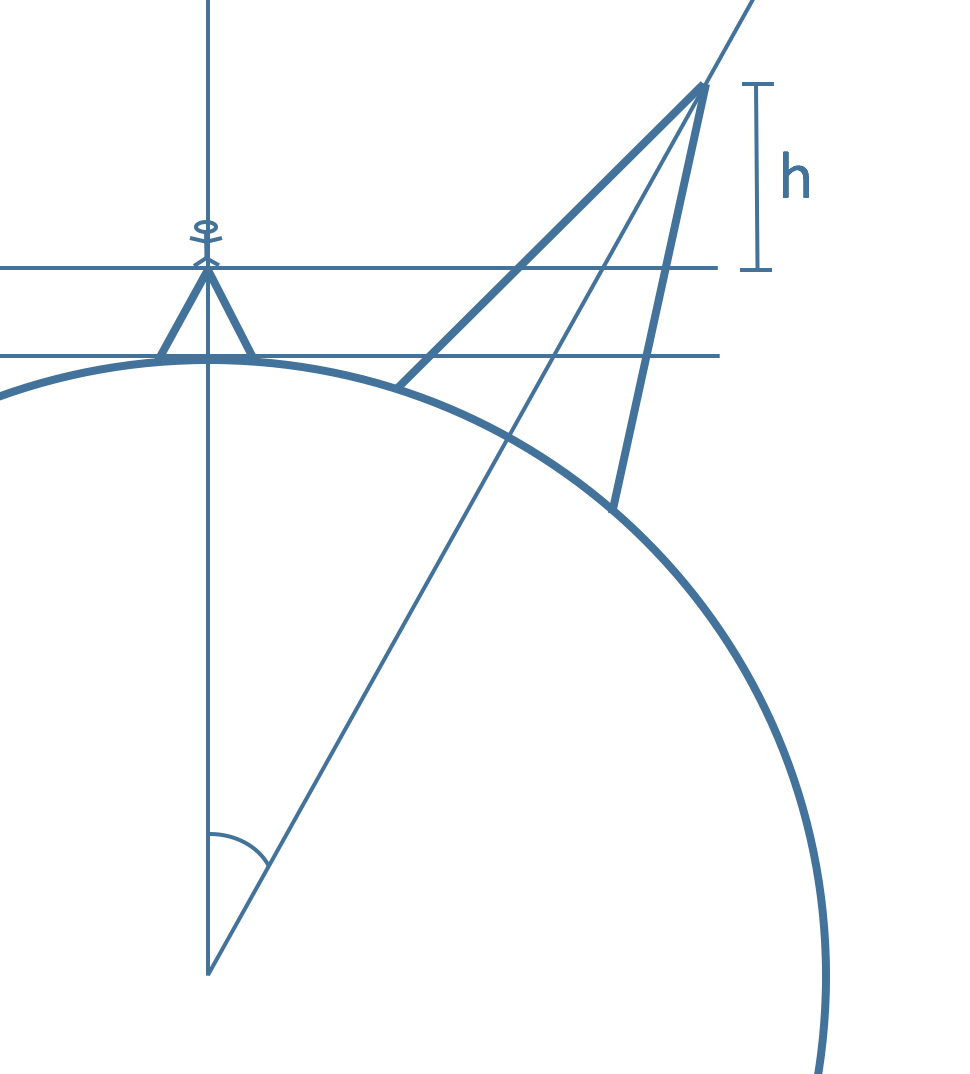

In [2]:
from IPython.display import Image
Image(filename='elevation_pic.png',width=300,height=200) 

To do this, I needed to calculate the tangent plane to the Earth at the first point and then find where that plane intercepts the mountain.

Equation for a unit sphere $$f(x,y,z)=x^2+y^2+z^2-1$$ 

To determine the tangent plane to the first coordinate, we take the derivate of each variable:

$$ \frac{df}{dx}(x,y,z)=2x,\frac{df}{dy}(x,y,z)=2y,\frac{df}{dz}(x,y,z)=2z$$

The line for the mountain from the center of the earth is just x + y + z multiplied by a constant (a). We are looking for where this equation equals the plane.

$$ 2x_0(\alpha x_1-x_0)+2y_0(\alpha y_1-y_0)+2z_0(\alpha z_1-z_0)=0$$

For a unit sphere $ x^2 + y^2 + z^2 = 1$

$$ \alpha x_0x_1+\alpha y_0y_1+\alpha z_0z_1= x_0^2+y_0^2+z_0^2$$

Subtract 1 to retain only the height of the hidden area (and remove the radius of the Earth) 

$$ \frac{1}{x_0x_1+y_0y_1+z_0z_1} - 1= height$$

The x, y, z coordinates can be replaced by the following formulas (all latitudes and longitudes need to be converted to radians)

$$ x = cos(lat) *cos(long)$$
$$y=sin(lat)$$
$$ z = cos(lat) *sin(long)$$

$$ \frac{1}{cos(lat_0)cos(long_0)cos(lat_1)cos(long_1)+sin(lat_0)sin(lat_1)+cos(lat_0)sin(long_0)cos(lat_1)sin(long_1)}-1= height$$

Reduced by: $ cos(x - y) = cos(x)cos(y)+sin(x)sin(y) $


This will give us the height of the mountain that is not hidden behind the curvature of the Earth

$$ \frac{1}{sin(lat_0)sin(lat_1)+cos(lat_0)cos(lat_1)cos(long_0 - long_1)}-1= height$$

However, this height does not take into account that it is at an angle to the first coordinate and needs to be perpendicular. As a result, we apply the cosine of the angle to the height. In order to find the angle (which is equal to the angle between the two coordinate lines), we use the following formula and solve for C:

$$ c^2=a^2+b^2-2ab*cos(C) $$

$$ arccos \left(1-\frac{c^2}{2}\right) = C$$

Where c is the distance between our two points. The distance can be determined using the following:


$$ distance = \sqrt{(x_1-x_0)^2+(y_1-y_0)^2+(z_1-z_0)^2} $$

$$ distance = \sqrt{(x_1^2+y_1^2+z_1^2)+(x_0^2+y_0^2+z_0^2)-2(x_0x_1-y_0y_1-z_0z_1)} $$

$$ distance = \sqrt{2(1-sin(lat_0)sin(lat_1)-cos(lat_0)cos(lat_1)cos(long_0 - long_1))} $$

Plugging back into the formula above to determine C, we get:

$$ arccos(sin(lat_0)sin(lat_1)+cos(lat_0)cos(lat_1)cos(long_0 - long_1)) = C $$

To get the visible height we now need to use this angle on the calculated height and subtract the distance that is hidden due to the first point being elevated:

$$ (elevation_1 - height) * cos(C) - elevation_0 = visible $$

$$ earth * \left(\frac{elevation_1}{earth} - \frac{1}{sin(lat_0)sin(lat_1)+cos(lat_0)cos(lat_1)cos(long_0 - long_1)}+1\right)*(sin(lat_0)sin(lat_1)+cos(lat_0)cos(lat_1)cos(long_0 - long_1)) - elevation_0$$

Written as cleanly as possible: 

$$ (EL_1+earth_r)*(sin(lat_0)sin(lat_1)+cos(lat_0)cos(lat_1)cos(long_0 - long_1))-(earth_r +EL_0) = Visible\,Height$$

### Assumptions

1) The Earth is perfectly round. I don't believe this will materially affect my result, but there would definitely be an impact. It presumably further decrease the visible height the closer you get to the equator where the Earth has more of a curve.

2) That anything with a negative elevation is below sea level which I have filtered from my data.

3) That 80 sq km is sufficient to get the major highs and lows in an area. I would like to get closer to 1 sq km but this will have to do. It does cause some issues for mountain peaks (registering presumably a lower value for each). In the next iteration I will get the data specifically for some of the highest mountains.

### Calculations

With the formula determined, I then needed to use the formula on the altitude data. However, this proved to be the most interesting part. Since you need to look at every location and compare it to every other location, it because a giant cross join on 6M data points--which is about 36 trillion comparisons.

The difficulty then depended on how many results that I wanted. To get the one highest result, I can run the query with the highest 1 or 2 normal elevations to return a starting point. Then I can use that value to filter my table so it is joining on much much fewer values. By doing this, I can return the top result in 1 or 2 seconds.

However, to return the top N results becomes much harder, and I decided instead to return all results greater than 3,000 metres. This helped greatly speed up the result. I also decided to exclude all water locations which I assumed all elevations with negative values. Lastly I calculated that from the highest point on Earth, if you were more than 312,000 metres away, you would not be able to see it. So I removed any coordinate pairs further than this distance away.

Unfortunately, other than the first filter to remove points less than 3,000 metres, the query still needed to evaluate the cross join first and then filter the data. So it was still performing calculations on an enormous amount of data that my 2014 MacBook Pro struggled with. I ran this query for over 24 before pulling the plug. Instead I increased it to 4,000 metres and it completed in a little over an hour.



In [ ]:
BEGIN

    DECLARE Earth INT;
    DECLARE ElevationDiff DOUBLE;
    DECLARE PIvar DOUBLE;
    DECLARE MaxDistance INT;
    DECLARE MaxHeight DOUBLE;
    DECLARE DistBtwnLat INT;
    SET DistBtwnLat = 112000;
    SET Earth = 6371000;
    SET PIvar = 2.0 / 360 * PI();
    SET MaxHeight = (SELECT MAX(elevation) FROM TBLelevationV1);
    SET ElevationDiff = 4000;
    SET MaxDistance = Earth*SQRT(2-2/((MaxHeight-ElevationDiff)/Earth+1));

    SELECT
      S1.LO1,
      S1.LA1,
      S1.EL1,
      S2.LO1,
      S2.LA1,
      S2.EL1,
      ((SIN(S1.LA1 * PIvar) * SIN(S2.LA1 * PIvar) + COS(S1.LA1 * PIvar) *
            COS(S2.LA1 * PIvar) * COS(S2.LO1 * PIvar - S1.LO1 * PIvar))*
       (S2.EL1/Earth+1)-1)*Earth-S1.EL1 AS VISIBLE
    FROM
      (SELECT
         T1.longitude AS LO1,
         T1.latitude  AS LA1,
         T1.elevation AS EL1
       FROM elevation.TBLelevation AS T1
       WHERE T1.elevation > 0 AND T1.elevation < (MaxHeight-ElevationDiff)) AS S1
      CROSS JOIN
      (SELECT
         T1.longitude AS LO1,
         T1.latitude  AS LA1,
         T1.elevation AS EL1
       FROM elevation.TBLelevation AS T1
       WHERE T1.elevation > ElevationDiff) AS S2
    WHERE ABS(S1.LA1 - S2.LA1) < (MaxDistance / DistBtwnLat)
      AND S2.EL1 - S1.EL1 > ElevationDiff
      AND (1 - (pow((MaxDistance / Earth), 2) / 2)) <
          (SIN(S1.LA1 * PIvar) * SIN(S2.LA1 * PIvar) + COS(S1.LA1 * PIvar) *
          COS(S2.LA1 * PIvar) * COS(S2.LO1 * PIvar - S1.LO1 * PIvar))
      AND ((SIN(S1.LA1 * PIvar) * SIN(S2.LA1 * PIvar) + COS(S1.LA1 * PIvar) *
            COS(S2.LA1 * PIvar) * COS(S2.LO1 * PIvar - S1.LO1 * PIvar))*
           (S2.EL1/Earth+1)-1)*Earth-S1.EL1 > ElevationDiff
    ORDER BY VISIBLE DESC;
END;

### Results



In [30]:
from IPython.display import display
import pandas as pd
df = pd.read_csv('results.csv', nrows=5, usecols=['LA1','LO1','EL1','LO1.1','LA1.1','EL1.1','VISIBLE']).head()
df['EL1'] = df['EL1'].round()
df['EL1.1'] = df['EL1.1'].round()
df['VISIBLE'] = df['VISIBLE'].round()
display(df)

,LO1,LA1,EL1,LO1.1,LA1.1,EL1.1,VISIBLE
0,87.2,27.3,288,87.1,27.9,7346,6701
1,83.6,28.3,813,83.5,28.7,7631,6655
2,83.6,28.1,686,83.5,28.7,7631,6588
3,83.3,27.7,127,83.5,28.7,7631,6503
4,83.4,27.7,158,83.5,28.7,7631,6495


Not surprisingly, albeit a little disappointing, the top 5 results are all from the Himalayas and Karakoram mountains. In fact, the first 450 results are from that region until Alaska pops up. The top 200 sets are shown below.

In [4]:
from IPython.display import IFrame
IFrame('elevation_topfar.html', width=900, height=500)

In [2]:
IFrame('elevation_top.html', width=900, height=500)

The map below shows the top ~12K results; all results with visibility >3K metres. It is still heavily concentrated in Asia but there are now a large number in South America and Alaska as well. 

In [3]:
IFrame('elevation.html', width=900, height=500)

### Alternative Solutions

Although the cross join is an effective way to solve the problem, it is not the most efficient as a cross join on 6M data points quickly takes me out of my 8GB of memory. The major problem is the cross join combines so many coordinates that are outside of the 312,000 metre radius that you need to be in to see any possible height. A better solution would be to somehow filter out those coordinates that are outside of that radius BEFORE any joins are made.

#### Alternative #1

My first alternative is to look to Python's Pandas--a data analytics package that many are familiar with. It is very good when it comes to making vectorized calculations. However, I quickly found that Pandas has one very limiting factor: although you can cross join just like in SQL, you cannot apply any where conditions until AFTER you have joined. Meaning that I still would need to create my 36 trillion points before filtering any of this data.

My solution to this was to subset the data and then join, iterating through groups of values.

Even when doing this, it quickly was too big for memory, so I found that I needed to subset into small groups, join, filter and then append together. I also tried to minimize space by casting all the latitudes and longitudes from 64bit integers into 16 bit integers. However, they then needed to be cast back into 64 bit integers or else it caused a loss in precision when applying trig functions to them.

I also tried subsetting the data by removing the elevations to reduce space and then joining the elevations back after removing all coordinate pairs that were too distant. However, the elevation component was a key filter early on, so this did not help me.

In the end I was left with the following solution:

In [ ]:
def find_visibility():

    DistBtwnLat = 112000
    Earth = 6371000
    PIvar = pi * 2.0 / 360.0
    MaxDistance = 224000
    maxDegrees = MaxDistance / DistBtwnLat

    query = """

    SELECT
        longitude,
        latitude,
        elevation,
        1 as merge
      FROM TBLelevationV1
      WHERE elevation > 0
      ORDER BY latitude, longitude

    """

    df_original = pd.read_sql(query, engine)

    df_original.latitude = df_original.latitude.astype(np.float16)
    df_original.longitude = df_original.longitude.astype(np.float16)
    df_original.elevation = df_original.elevation.astype(np.int16)

    df_valley = df_original[['latitude', 'longitude', 'elevation', 'merge']]
    df_mountain = df_original[df_original.elevation > 4000][['latitude', 'longitude', 'elevation', 'merge']]
    del df_original['merge']

    split = 10
    splitlong = 10
    counter = 0

    for k in range(split):
        for j in range(splitlong):
            i = k
            df = df_valley[(df_valley.latitude >= (-90 + i * 180/split)) & 
                           (df_valley.latitude < (-90 + (i+1) * 180/split)) & 
                           (df_valley.longitude >= (-180 + j * 360/splitlong)) & 
                           (df_valley.longitude < (-180 + (j+1) * 360/splitlong))]
            print (1.0 * i*split + j)/(split*splitlong)
            df = df.merge(df_mountain[(df_mountain.latitude >= (-90 + i * 180/split - maxDegrees)) & 
                                      (df_mountain.latitude < (-90 + (i+1) * 180/split + maxDegrees)) & 
                                      (df_mountain.longitude >= (-180 + j * 360/splitlong - maxDegrees)) & 
                                      (df_mountain.longitude < (-180 + (j+1) * 360/splitlong + maxDegrees))], 
                          on="merge", copy=False)

            if df.empty==False:
                del df['merge']

                df = df.ix[df['elevation_y'] - df['elevation_x'] > 4000]

                counter += 1
                if counter == 10:
                    counter = 0

                    df['visible'] = ((1.0 / (cos(df['latitude_x'].astype(np.float64) * PIvar) *
                                             cos(df['latitude_y'].astype(np.float64) * PIvar) *
                                             cos(df['longitude_x'].astype(np.float64) * PIvar -
                                                 df['longitude_y'].astype(np.float64) * PIvar)  - 1)) * \
                        Earth) + df['elevation_x']

                    df = df.sort(['visible'], ascending=False)
                    df = df.iloc[0:1000]

                try:
                    final_df = final_df.append(df)
                except:
                    final_df = df

        dist = (1 - ((MaxDistance*1.0 / Earth)**2) / 2)

        try:
            final_df = final_df[dist < \
                cos(df['latitude_x'].astype(np.float64) * PIvar) *
                                             cos(df['latitude_y'].astype(np.float64) * PIvar) *
                                             cos(df['longitude_x'].astype(np.float64) * PIvar -
                                                 df['longitude_y'].astype(np.float64) * PIvar)]
        except:
            pass

    try:
        df = final_df
    except:
        pass

    df['visible'] = ((1.0 / (cos(df['latitude_x'].astype(np.float64) * PIvar) *
                                             cos(df['latitude_y'].astype(np.float64) * PIvar) *
                                             cos(df['longitude_x'].astype(np.float64) * PIvar -
                                                 df['longitude_y'].astype(np.float64) * PIvar)  - 1)) * \
                        Earth) + df['elevation_x']

    df = df[df.visible > 0]

    df = df.merge(df_original, left_on=['latitude_y','longitude_y'], right_on=['latitude','longitude'], 
                  copy=False)[['latitude_x','longitude_x','latitude_y','longitude_y',
                               'elevation_x','elevation_y','visible']]
    df['visible'] = df.elevation_y - df.visible
    df = df[df.visible > 0]
    df = df.sort(['visible'], ascending=False)
    return df

#### Alternative #2

Since the key seems to be splitting the data and then joining it, this seems like an ideal problem for mapreduce. I cannot use it solely on my system since mapreduce won't help my problem with running out of memory. My next attempt will be to try Hadoop and see if that can speed up my solution.

<a href="http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html">

<a href="http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html">